In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import InputLayer, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/S_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Indian_Extent = pd.read_excel(filepath, sheet_name='Indian-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/SH/Bi_LSTM_Extent/')
import Function as fp

In [4]:
fp.month_mapping(Indian_Extent)
fp.date_time(Indian_Extent)

,Extent,Date
0,376618.799,1979-01-01
1,211788.726,1979-02-01
2,262868.141,1979-03-01
3,698377.304,1979-04-01
4,1252407.727,1979-05-01
...,...,...
533,1520776.003,2023-06-01
534,2076164.165,2023-07-01
535,2731799.027,2023-08-01
536,3179384.692,2023-09-01


In [5]:
scaler = MinMaxScaler()
Indian_Extent['Extent'] = scaler.fit_transform(Indian_Extent['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 6
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Indian_Extent['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((521, 12, 1), (521,))

In [8]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0)))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Indian_model_LT6/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
import time

stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 17s 212ms/step - loss: 0.2447 - root_mean_squared_error: 0.4947 - val_loss: 0.1734 - val_root_mean_squared_error: 0.4164
Epoch 2/50
53/53 [==============================] - 7s 134ms/step - loss: 0.1244 - root_mean_squared_error: 0.3527 - val_loss: 0.0759 - val_root_mean_squared_error: 0.2755
Epoch 3/50
53/53 [==============================] - 6s 117ms/step - loss: 0.0860 - root_mean_squared_error: 0.2932 - val_loss: 0.0711 - val_root_mean_squared_error: 0.2666
Epoch 4/50
53/53 [==============================] - 10s 194ms/step - loss: 0.0815 - root_mean_squared_error: 0.2855 - val_loss: 0.0672 - val_root_mean_squared_error: 0.2592
Epoch 5/50
53/53 [==============================] - 10s 192ms/step - loss: 0.0752 - root_mean_squared_error: 0.2742 - val_loss: 0.0623 - val_root_mean_squared_error: 0.2496
Epoch 6/50
53/53 [==============================] - 10s 184ms/step - loss: 0.0688 - root_mean_squared_error: 0.2624 - val_loss: 0.0554 - 

53/53 [==============================] - 9s 179ms/step - loss: 0.0099 - root_mean_squared_error: 0.0997 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0787
Epoch 28/50
53/53 [==============================] - 10s 195ms/step - loss: 0.0104 - root_mean_squared_error: 0.1021 - val_loss: 0.0058 - val_root_mean_squared_error: 0.0764
Epoch 29/50
53/53 [==============================] - 10s 193ms/step - loss: 0.0098 - root_mean_squared_error: 0.0990 - val_loss: 0.0056 - val_root_mean_squared_error: 0.0749
Epoch 30/50
53/53 [==============================] - 2s 31ms/step - loss: 0.0109 - root_mean_squared_error: 0.1046 - val_loss: 0.0057 - val_root_mean_squared_error: 0.0753
Epoch 31/50
53/53 [==============================] - 2s 32ms/step - loss: 0.0076 - root_mean_squared_error: 0.0873 - val_loss: 0.0058 - val_root_mean_squared_error: 0.0759
Epoch 32/50
53/53 [==============================] - 2s 32ms/step - loss: 0.0074 - root_mean_squared_error: 0.0862 - val_loss: 0.0057 - val_root_me

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

5.956885325908661 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

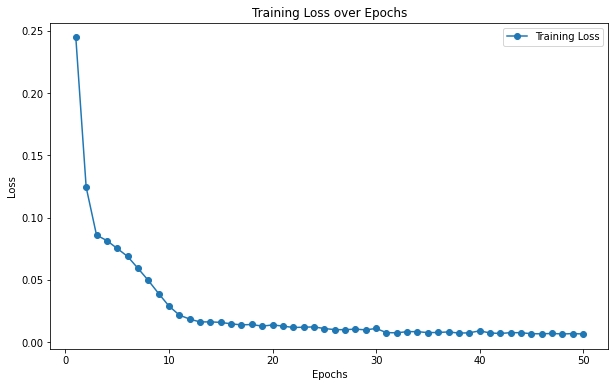

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

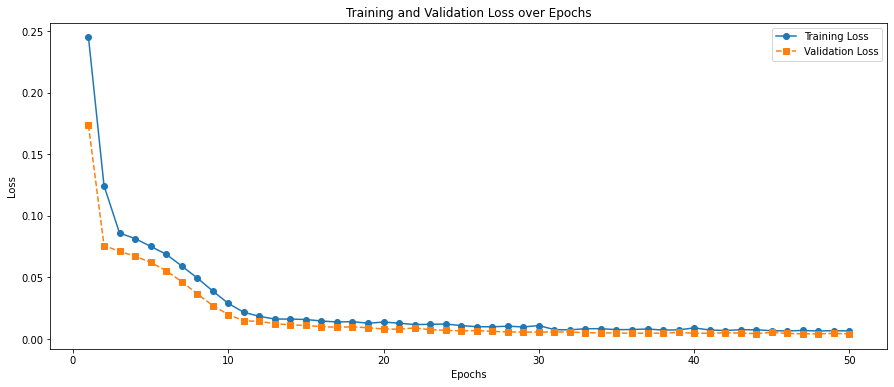

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Indian_model_LT6/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 1s 24ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.0573372196424845
MAE : 0.04766728083459004


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,3.556918e+06,3636501.241
1,2.838804e+06,2526913.818
2,1.365417e+06,1128752.378
3,4.905472e+05,522831.371
4,1.210936e+05,346601.304
5,6.369371e+04,444914.605
6,3.759087e+05,827036.916
7,1.218914e+06,1142021.216
8,1.691342e+06,1885693.654
9,2.201488e+06,2542569.663


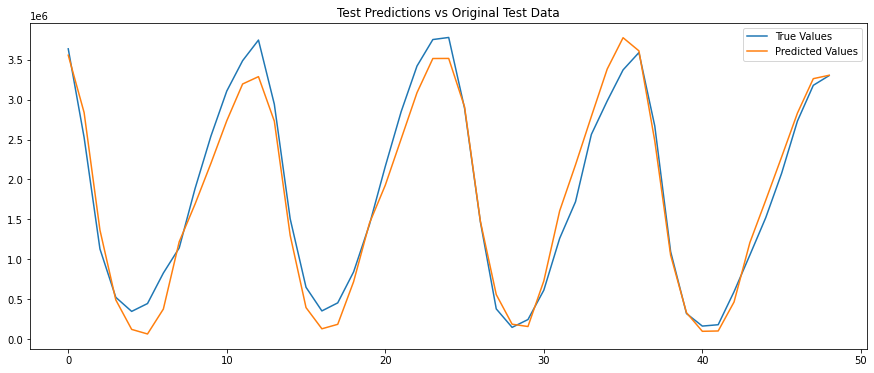

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

17/17 [==============================] - 0s 14ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

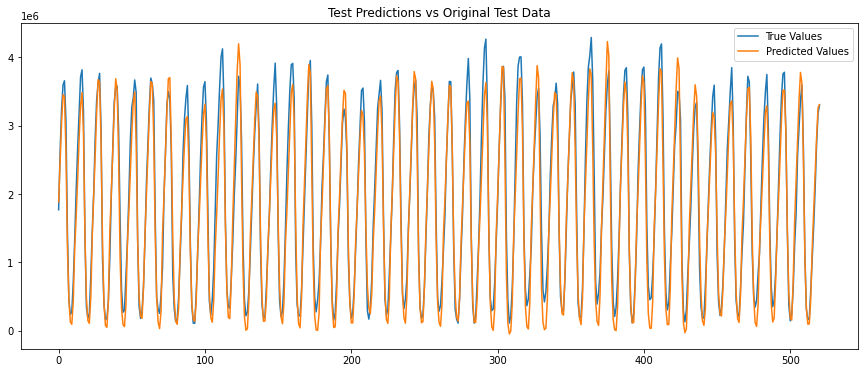

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()